In [2]:
import json
from datetime import datetime

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
def find_component(node, connected_components):
    for i, component in enumerate(connected_components):
        if node in component:
            return i
    raise ValueError(f'Component for node {node} not found')

In [4]:
def cascade_remove_links(Ga, Gb):

    keep_going = True
    while keep_going:
        keep_going = False

        clusters_a = list(nx.connected_components(Ga))
        for edge in Gb.edges():
            if find_component(edge[0], clusters_a) != find_component(edge[1], clusters_a):
                keep_going = True
                Gb.remove_edge(*edge)

        clusters_b = list(nx.connected_components(Gb))
        for edge in Ga.edges():
            if find_component(edge[0], clusters_b) != find_component(edge[1], clusters_b):
                keep_going = True
                Ga.remove_edge(*edge)
    
    return Ga, Gb

In [5]:
def articulation_points_multiplex(G1, G2):
    ap1 = set(nx.articulation_points(G1))
    ap2 = set(nx.articulation_points(G2))
    return ap1.union(ap2)

In [6]:
def remove_ap(G1, G2):
    G1, G2 = cascade_remove_links(G1, G2)

    art_points = articulation_points_multiplex(G1, G2)
    gcc_size = max(len(comp) for comp in nx.connected_components(G1))

    # np.save('n_ap', n_ap)
    # np.save('gcc_size', gcc_size)

    G1.remove_nodes_from(art_points)
    G2.remove_nodes_from(art_points)

    return G1, G2, art_points, gcc_size

In [7]:
def multiplex_network(N, c):
    G1 = nx.erdos_renyi_graph(N, c / (N-1))
    G2 = nx.erdos_renyi_graph(N, c / (N-1))
    return G1, G2

In [8]:
def dt():
    return str(datetime.now()).replace(':', '-')

In [14]:
crange = np.linspace(0, 7, 100)
N = 10_000
nruns = 100

In [24]:
results = []
for c in tqdm(crange):

    results.append({})
    results[-1]['c'] = c
    results[-1]['runs'] = []

    for run_id in range(nruns):

        results[-1]['runs'].append({})
        current_run = results[-1]['runs'][-1]
        current_run['run_id'] = run_id
        current_run['cascade'] = []
    
        G1, G2 = multiplex_network(N, c)

        while True:

            current_run['cascade'].append({'t': current_run['cascade'][-1]['t'] + 1
                                                if current_run['cascade']
                                                else 0})
            G1, G2, art_points, gcc_size = remove_ap(G1, G2)
            current_run['cascade'][-1]['n_ap'] = len(art_points)
            current_run['cascade'][-1]['gcc_size'] = gcc_size

            if not art_points:
                break

with open(f'results_{dt()}.json', 'w') as json_file:
    json.dump(results, json_file, indent=4)

100%|██████████| 100/100 [39:40:44<00:00, 1428.45s/it]  


In [9]:
with open('results.json', 'r') as json_file:
    results = json.load(json_file)

In [11]:
T = []
for result in results:
    T.append(np.mean([
        max(item['t'] for item in run['cascade'])
        for run in result['runs']
    ]))

max_t = max(item['t']
            for result in results
            for run in result['runs']
            for item in run['cascade'])

In [12]:
max_t

81

In [15]:
n_ap = {t: [] for t in range(max_t + 1)}
gcc_size = {t: [] for t in range(max_t + 1)}

for result in results:

    n_ap_loc = {t: 0. for t in range(max_t + 1)}
    gcc_size_loc = {t: 0. for t in range(max_t + 1)}

    for run in result['runs']:
        for item in run['cascade']:

            n_ap_loc[item['t']] += item['n_ap']
            gcc_size_loc[item['t']] += item['gcc_size']

    for t in range(max_t + 1):

        n_ap[t].append(n_ap_loc[t] / nruns / N)
        gcc_size[t].append(gcc_size_loc[t] / nruns / N)

In [16]:
gcc_inf = []
for i, t in enumerate(np.rint(T)):
    gcc_inf.append(gcc_size[t][i])

In [17]:
lw, ms = 1, 3

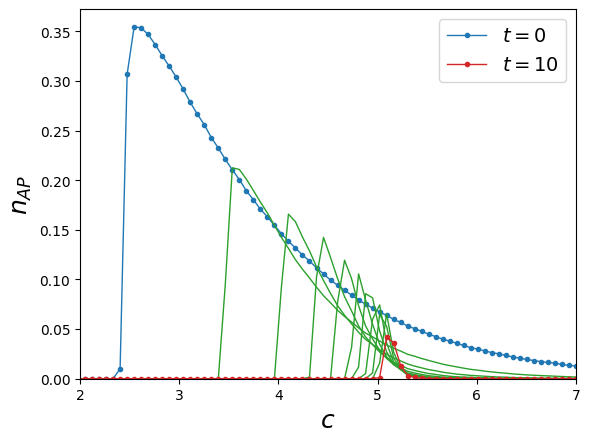

In [18]:
plt.plot(crange, n_ap[0], 'o-', lw=lw, ms=ms, color='tab:blue', label='$t = 0$')
max_t_for_plots = 10
for t in range(1, max_t_for_plots):
    plt.plot(crange, n_ap[t], '-', lw=lw, ms=ms, color='tab:green')
plt.plot(crange, n_ap[max_t_for_plots], 'o-', lw=lw, ms=ms, color='tab:red', label=f'$t = {max_t_for_plots}$')
plt.xlim(2, 7)
plt.ylim(bottom=0)
plt.xlabel('$c$', fontdict={'size': 18})
plt.ylabel('$n_{AP}$', fontdict={'size': 18})
plt.legend(fontsize=14)
plt.savefig(f'AP_{dt()}.png')

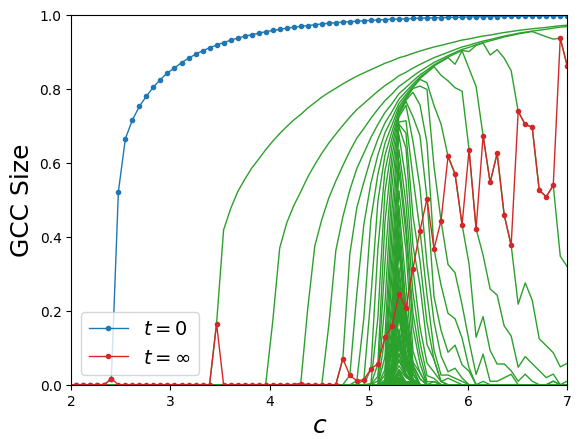

In [19]:
plt.plot(crange, gcc_size[0], 'o-', lw=lw, ms=ms, color='tab:blue', label='$t = 0$')
for t in range(1, max_t + 1):
    plt.plot(crange, gcc_size[t], '-', lw=lw, ms=ms, color='tab:green')
plt.plot(crange, gcc_inf, 'o-', lw=lw, ms=ms, color='tab:red', label='$t = \infty$')
plt.xlim(2, 7)
plt.ylim(0, 1)
plt.xlabel('$c$', fontdict={'size': 18})
plt.ylabel('GCC Size', fontdict={'size': 18})
plt.legend(fontsize=14)
plt.savefig(f'GCC_size_{dt()}.png')

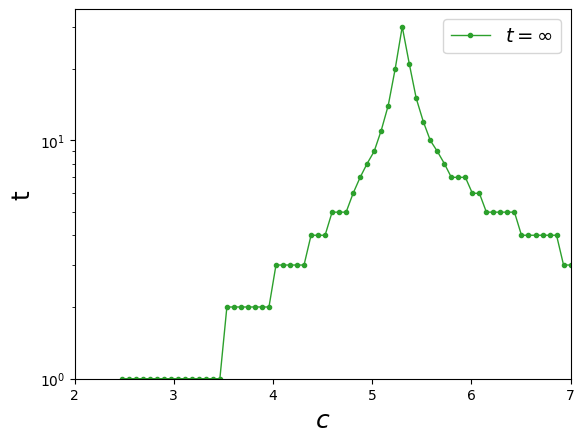

In [20]:
plt.semilogy(crange, np.rint(T), 'o-', ms=ms, lw=lw, color='tab:green', label='$t = \infty$')
plt.xlim(2, 7)
plt.ylim(bottom=1)
plt.xlabel('$c$', fontdict={'size': 18})
plt.ylabel('t', fontdict={'size': 18})
plt.legend(fontsize=14)
plt.savefig(f't_{dt()}.png')